# SMCNOD
This notebook presents the mixture model of 3 gaussians built for SMCNOD data. The data is taken from the S5 Collaboration. With quality cut, we obtained 371 stars with good measurements to feed the model. The mixture model is built with 16 parameters, including radial velocity, metallicity and proper motion parameters of the smcnod and a set of parameters for the background components. We fit a Gaussian mixture model to this data using `emcee`.

In [2]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp

## SMCNOD Data

In [4]:
with fits.open('s5cat_si_dr3_1.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
RA, DEC = 12, -64.8 # deg
cut_r = 1.05 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# 1700d: red arm measure more RGB
# 580v: blue arm more BHB
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
largetrial = (c1 | c2) & (table_cut['good_star_pb'] > 0.5) & (table_cut['vel_calib_std'] < 10)
table_cut = table_cut[largetrial]
# selected member, not used for building model
metalpoor = table_cut['feh50'] < -1.5
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] )  &  ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)
smcnod = table_cut[sel_peak][peak_pm]
tab = smcnod

In [3]:
len(tab)

150

In [4]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

Text(0.5, 0, 'pmdec')

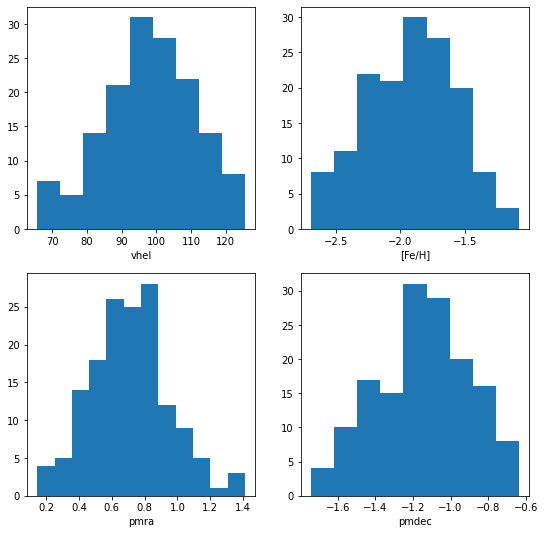

In [5]:
fig, axes = plt.subplots(2,2,figsize=(9,9))
axes[0,0].hist(rv, bins='auto');
axes[0,0].set_xlabel("vhel")
axes[0,1].hist(feh, bins='auto');
axes[0,1].set_xlabel("[Fe/H]")
axes[1,0].hist(pmra, bins='auto');
axes[1,0].set_xlabel("pmra")
axes[1,1].hist(pmdec, bins='auto');
axes[1,1].set_xlabel("pmdec")

In [6]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]

We will model the smcnod data as a mixture of 3 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pbg1 = fraction of stars in the 1st background component
* pmra = Heliocentric proper motion, RA of the galaxy in mas/yr
* pmdec = Heliocentric proper motion, Dec of the galaxy in mas/yr
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component
* vbg2, lsigvbg2, fehbg2, lsigfeh2 = same parameters for 2nd background component

In total there are 16 parameters.

# Likelihood function

In [7]:
data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [12]:
param_labels = ["vhel","lsigv","feh","lsigfeh","pmra","pmdec"]
def full_like(theta):
    """ Likelihood and Prior """
    vhel, lsigv, feh0, lsigfeh, pmra_gal, pmdec_gal = theta
    
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    # The prior is just a bunch of hard cutoffs
    if (lsigv > 3) or (lsigv < -1) or (lsigfeh > 1) or (lsigfeh < -3) or (vhel > 400) or (vhel < -100)or \
        (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2):
        return -1e10   
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2)) 
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))  
    # Compute log likelihood in proper motions
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]
    
    # Combine the components
    lgal = lgal_vhel+lgal_pm+lgal_feh
    return lgal.sum()

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

# Optimize parameters



In [13]:
## I found this guess by looking at the plot by eye and estimating. This part requires some futzing.
p0_guess = [98, 1, -2.2,-0.4,0.7, -1.1]

In [14]:
optfunc = lambda theta: -full_like(theta)

In [15]:
%timeit optfunc(p0_guess)

9.98 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
optfunc(p0_guess)

695.9524651495052

In [17]:
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")

CPU times: user 4.79 s, sys: 65.4 ms, total: 4.85 s
Wall time: 4.8 s


In [18]:
res.x

array([97.71328898,  1.1009775 , -1.90634982, -0.51787065,  0.70379526,
       -1.13500718])

In [19]:
optfunc(res.x)

648.0333612860861

In [20]:
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

vhel: 97.713
lsigv: 1.101
feh: -1.906
lsigfeh: -0.518
pmra: 0.704
pmdec: -1.135


## Posterior Sampling
The posterior is sampled using `emcee` with 64 walkers and 10,000 steps per chain.

In [22]:
nw = 64
p0 = res['x']
nit = 2000
ep0 = np.zeros(len(p0_guess)) + 0.02
p0s = np.random.multivariate_normal(p0_guess, np.diag(ep0)**2, size=nw)
# print(p0s)

In [24]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
p0 = p0_guess
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [full_like(p0s[j]) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

6


In [26]:
import emcee
def get_rstate():
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))
#from schwimmbad import MultiPool
#pool = MultiPool(4)
es = emcee.EnsembleSampler(
    nw, len(p0_guess), full_like)

In [27]:
%time PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
es.reset()

CPU times: user 21min 9s, sys: 6.3 s, total: 21min 16s
Wall time: 21min 13s


In [28]:
%time es.run_mcmc(PP.coords, nit, rstate0=get_rstate())
np.save("results_smcnod.npy",es.flatchain)

CPU times: user 21min 14s, sys: 7.2 s, total: 21min 21s
Wall time: 21min 20s


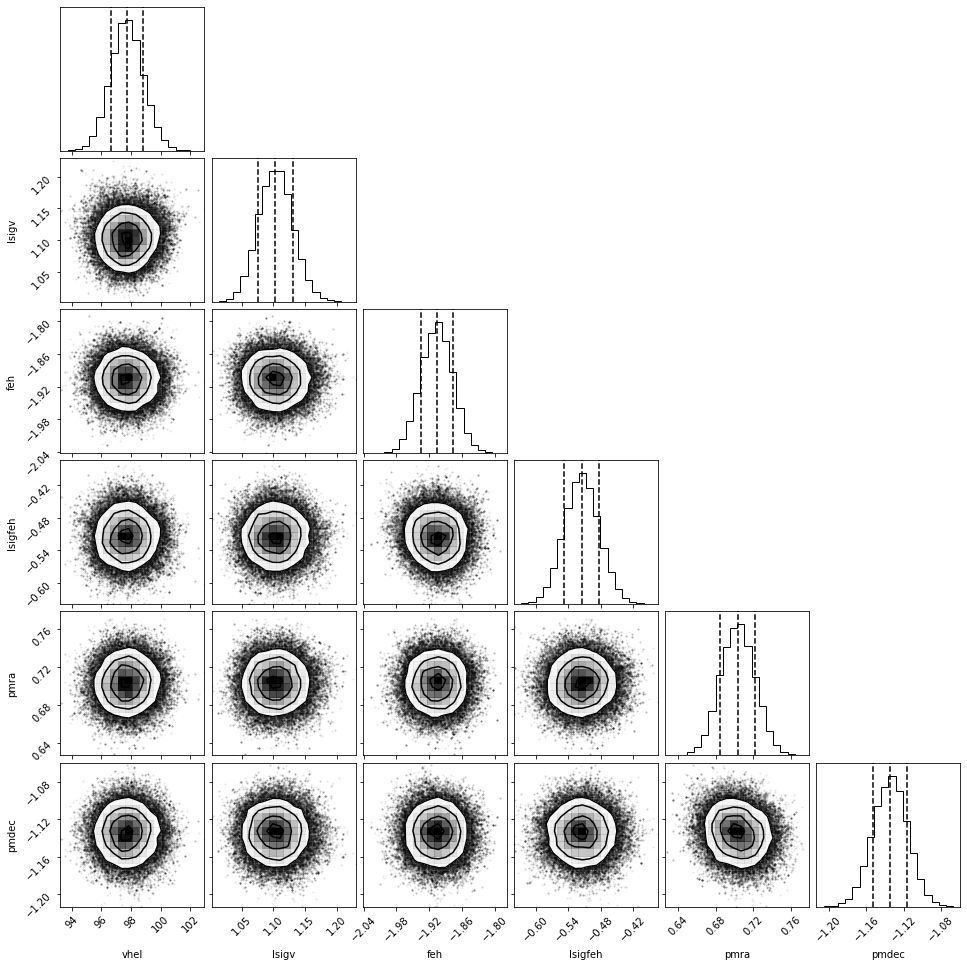

In [29]:
outputs = es.flatchain
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84])
plt.savefig('fullmodel.png')

In [112]:
param_labels = ["vhel","lsigv","feh","lsigfeh","pmra","pmdec"]

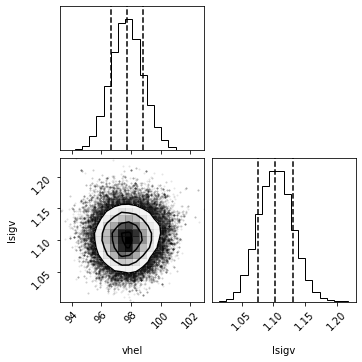

In [31]:
outputs = es.flatchain
fig1 = corner.corner(outputs[:,0:2], labels=param_labels[0:2], quantiles=[0.16,0.50,0.84])

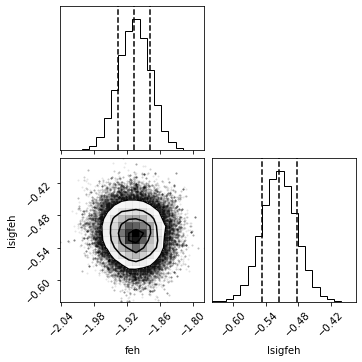

In [32]:
fig2 = corner.corner(outputs[:,2:4], labels=param_labels[2:4], quantiles=[0.16,0.50,0.84])

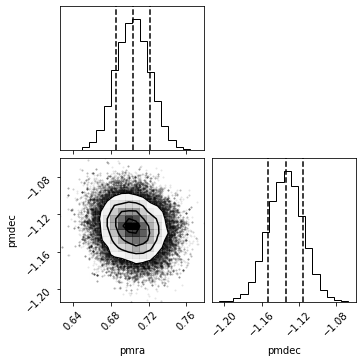

In [33]:
fig3 = corner.corner(outputs[:,4:6], labels=param_labels[4:6], quantiles=[0.16,0.50,0.84])

In [34]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [35]:
meds, errs = process_chain(outputs)

In [36]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

vhel 97.716 1.085
lsigv 1.104 0.027
feh -1.906 0.029
lsigfeh -0.515 0.032
pmra 0.703 0.018
pmdec -1.134 0.019


If things are well mixed, then you can just use the flat chain to concatenate all the walkers and steps.
The results here may not be perfectly mixed, but it's not terrible.
There are fancy ways to check things here involving autocorrelation times that Alex does not know about.
To me this is the hard part of emcee: knowing when you're happy with the result, and setting things up so that it gets there as fast as possible. This is why I prefer dynesty, even though it's slower it has a motivated stopping condition.

In [39]:
chain = es.flatchain
chain.shape

(128000, 6)

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

In [40]:
chain_new = 10**chain

In [41]:
mean_vdisp = np.percentile(chain_new, 50)
mean_vdisp

2.3272767144610933

In [43]:
chain_new = 10**chain
mean_vdisp = np.percentile(chain_new[:,1], 50)
std_vdisp = (np.percentile(chain_new[:,1], 84)-np.percentile(chain_new[:,1], 16))/2
mean_fehdisp = np.percentile(chain_new[:,3], 50)
std_fehdisp = (np.percentile(chain_new[:,3], 84)-np.percentile(chain_new[:,3], 16))/2
print("mean_vdisp: ",mean_vdisp, \
     "std_vdisp: ",std_vdisp)
print("mean_fehdisp: ",mean_fehdisp, \
     "std_fehdisp: ",std_fehdisp)

mean_vdisp:  12.69117771584777 std_vdisp:  0.787461693416124
mean_fehdisp:  0.3054303486863548 std_fehdisp:  0.022552876673532646


## Member Probability

In [205]:
pgal = 0.471
pbg1 = 0.571
vhel = 102.296
lsigv = 1.380
feh = -1.900
lsigfeh = -0.516
vbg1 = 140.157
lsigvbg1 = 1.967
fehbg1 = -1.305
lsigfeh1 = -0.373
vbg2 = 27.487
lsigvbg2 = 1.626
fehbg2 = -0.681
lsigfeh2 = -0.498
pmra1 = 0.703
pmdec1 = -1.123

theta_opt = pgal, pbg1, vhel, lsigv, feh, lsigfeh, vbg1, lsigvbg1, fehbg1, lsigfeh1, vbg2, lsigvbg2, fehbg2, lsigfeh2, pmra1, pmdec1

In [243]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

In [244]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]

In [245]:
 def memprob(theta):
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal = theta
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    #lgal
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))    
    ## Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2)) 
    ## Compute log likelihood in pm
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh + lgal_pm
    ## exp of log
    gal = 10**lgal
    
    ## bg1
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))   
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg1_pm = np.log(data["pmnorm"])
    ## Combine the components
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh + lbg1_pm
    
    # bg2
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    lbg2_pm = np.log(data["pmnorm"])
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh + lbg2_pm
    
    # combine bg1 and bg2
    lbgtot = np.logaddexp(lbg1, lbg2)
    bg = 10**lbgtot
    
    # member probability
    p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)
    return p

In [241]:
def memprob(theta):
    #lgal
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))    
    ## Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2)) 
    ## Compute log likelihood in pm
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh + lgal_pm
    ## exp of log
    gal = 10**lgal
    
    ## bg1
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))   
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg1_pm = np.log(data["pmnorm"])
    ## Combine the components
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh + lbg1_pm
    
    # bg2
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    lbg2_pm = np.log(data["pmnorm"])
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh + lbg2_pm
    
    # combine bg1 and bg2
    lbgtot = np.logaddexp(lbg1, lbg2)
    bg = 10**lbgtot
    
    # member probability
    p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)
    return p

In [258]:
sum(memprob(theta_opt) > 0.999)

175

In [259]:
tab_good = tab[memprob(theta_opt) > 0.5]

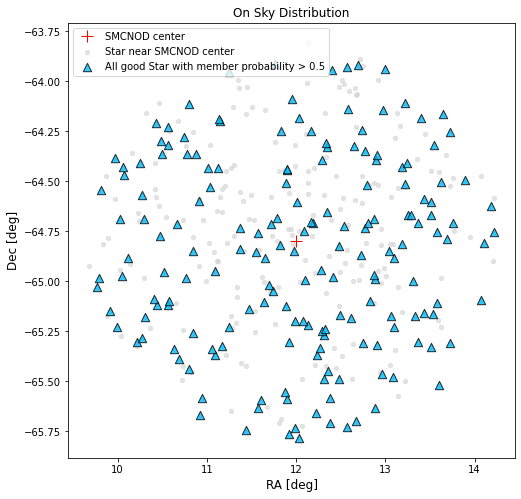

In [260]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='^', s=70, c='deepskyblue', ec='k', zorder=3, alpha=0.8,
        label='All good Star with member probability > 0.5')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()

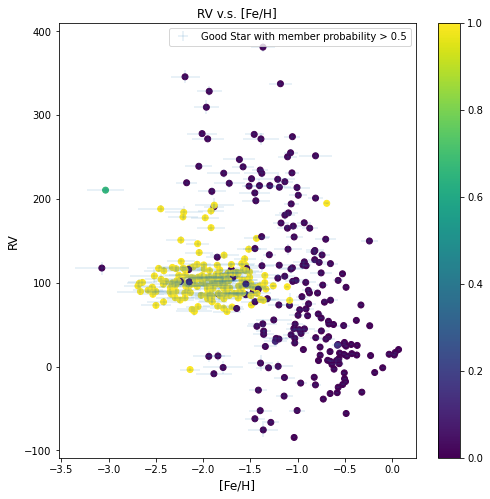

In [262]:
plt.subplots(figsize=(8,8))
plt.scatter(tab['feh50'], tab['vel_calib'], c=memprob(theta_opt),cmap='viridis')
plt.errorbar(tab['feh50'], tab['vel_calib'], xerr=tab['feh_std'], yerr=tab['vel_calib_std'], fmt='None', marker='None',lw=0.2,label='Good Star with member probability > 0.5')
#plt.errorbar(smcnod['feh50'], smcnod['vel_calib'], xerr=smcnod['feh_std'], yerr=smcnod['vel_calib_std'], fmt='o', mfc='none',ms=25, c='deepskyblue',label="All good Star star in member selection")
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.title('RV v.s. [Fe/H]')
plt.colorbar()
plt.legend()

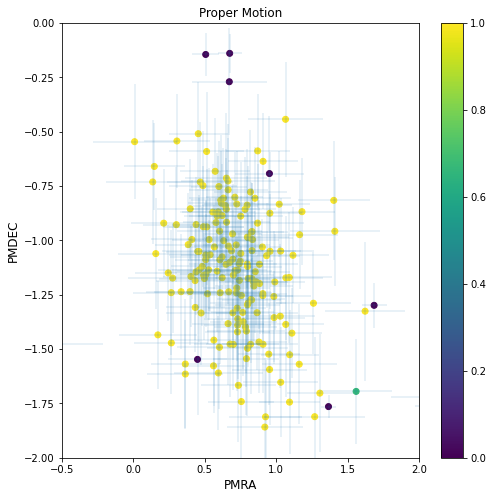

In [261]:
plt.subplots(figsize=(8,8))
plt.scatter(tab['pmra'], tab['pmdec'], c=memprob(theta_opt),cmap='viridis')
plt.errorbar(tab['pmra'], tab['pmdec'], xerr=tab['pmra_error'], yerr=tab['pmdec_error'], fmt='None', marker='None',lw=0.2)
plt.xlim(-0.5,2)
plt.ylim(-2,0)
#plt.errorbar(smcnod['pmra'], smcnod['pmdec'], xerr=smcnod['pmra_error'], yerr=smcnod['pmdec_error'], fmt='o', mfc='none',ms=5.5, c='k',lw=0.2,label="All good Star star in member selection")
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
plt.colorbar()